In [1]:
%run util.ipynb

In [2]:
import os;os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
import time
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn
from torch.utils.data import DataLoader, TensorDataset, Dataset

from tqdm import tqdm

Defining some parameters.

In [4]:
SEED = 20193575

# Training weeks end at MAX_WEEK - 1
N_TRAINING_WEEKS = 5
MAX_WEEK = 105

# Possible values: "product_type_name", "prod_name", "article_id", not tested with any other feature
SEQUENCE_COLUMN = "product_type_name"
BASE_PATH = f"./models/{SEQUENCE_COLUMN}" + (f"_{MAX_WEEK}/" if MAX_WEEK != 105 else "/")

In [5]:
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
assert torch.cuda.is_available(), "CUDA is not available, training will be slow."

In [7]:
articles = pd.read_parquet('../data/articles.parquet')
customers = pd.read_parquet('../data/customers.parquet')
transactions = pd.read_parquet('../data/transactions_train.parquet')
sample_submission = pd.read_csv('../data/sample_submission.csv')

# Simple preprocessing

In [8]:
# get the needed article features and merge them into the transactions
transactions = pd.merge(transactions, articles[["article_id", "prod_name", "product_type_name"]], on="article_id", how="left")

In [9]:
# map the article ids to a continuous range, only used if we want to use the article ids as input
article_id_map = {original: (idx + 1) for idx, original in enumerate(articles["article_id"].unique())}
inverse_article_id_map = {(idx + 1): original for idx, original in enumerate(articles["article_id"].unique())}
articles["article_id_mapped"] = articles["article_id"].map(article_id_map)
transactions["article_id_mapped"] = transactions["article_id"].map(article_id_map)

In [10]:
articles.nunique()

article_id                      105542
product_code                     47224
prod_name                        45875
product_type_no                    132
product_type_name                  131
product_group_name                  19
graphical_appearance_no             30
graphical_appearance_name           30
colour_group_code                   50
colour_group_name                   50
perceived_colour_value_id            8
perceived_colour_value_name          8
perceived_colour_master_id          20
perceived_colour_master_name        20
department_no                      299
department_name                    250
index_code                          10
index_name                          10
index_group_no                       5
index_group_name                     5
section_no                          57
section_name                        56
garment_group_no                    21
garment_group_name                  21
detail_desc                      43405
article_id_mapped        

## Training

In [11]:
# Split 80/20 on customer id
train_customers, val_customers = train_test_split(transactions.customer_id.unique(), test_size=0.2, random_state=SEED)
training_transactions_df = transactions[transactions.customer_id.isin(train_customers)]
validation_transactions_df = transactions[transactions.customer_id.isin(val_customers)]

In [12]:
training_transactions = filter_transactions_by_weeks(training_transactions_df, SEQUENCE_COLUMN)

In [13]:
validation_transactions = filter_transactions_by_weeks(validation_transactions_df, SEQUENCE_COLUMN)

Some sanity checks quick in between

In [14]:
articles["product_type_name"].unique()

array([  9,  13,  37,  14,  15,   2,   4,   0,  48,  81,  43,  29,  50,
        64,  12, 103,  30,  39,  27,  31,  20,  10,  33,  11,   3,   1,
        18,  66,   7,   8,  36,  24,  16,  34,  17,  45,  22,  21,  25,
        42,  23,  32,   6,  67,  61,  28,  38,  26,  40,  47,  57, 100,
       101,  41,  70,  35,  44,  60,  51,  92,  55,   5,  72,  69,  56,
        73,  88,  75,  46,  62,  68,  53,  74,  58,  19,  49,  83,  65,
        80,  59,  54,  63, 109,  79,  77,  52,  87, 110,  78,  82,  98,
       121,  86,  76,  71,  95, 129, 116, 115,  94, 128, 102,  91,  97,
        93,  84,  90, 112,  89,  99, 127, 108, 126,  85, 125, 124, 104,
       106, 123, 122, 111, 107, 120, 118, 105, 119,  96, 113, 114, 117,
       130], dtype=int16)

In [15]:
transactions.customer_id.value_counts().describe()

count    1.362281e+06
mean     2.333463e+01
std      3.924225e+01
min      1.000000e+00
25%      3.000000e+00
50%      9.000000e+00
75%      2.700000e+01
max      1.895000e+03
Name: count, dtype: float64

In [16]:
training_transactions_df.customer_id.value_counts().median()

9.0

Defining hyperparameters and other constants

In [17]:
EMBEDDING_DIM = 64
HIDDEN_DIM = 100

BATCH_SIZE = 128

# Padding article added to map, actual articles start at 1
article_id_map[-1] = 0
PADDING_ARTICLE = articles[SEQUENCE_COLUMN].nunique() if SEQUENCE_COLUMN != "article_id" else 0

NUM_ARTICLES_IN_SEQUENCE = 12
N_ARTICLES = articles[SEQUENCE_COLUMN].nunique()

model = LSTMRecommender(
    input_dim=NUM_ARTICLES_IN_SEQUENCE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    n_articles=N_ARTICLES+1,
    bidirectional=False,
    num_layers=1,
    dropout=0.2
    )

loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Some more sanity checks

In [18]:
articles[SEQUENCE_COLUMN].describe()

count    105542.000000
mean         12.750573
std          15.250827
min           0.000000
25%           2.000000
50%           7.000000
75%          18.000000
max         130.000000
Name: product_type_name, dtype: float64

In [19]:
articles[SEQUENCE_COLUMN].max() - articles[SEQUENCE_COLUMN].min()

130

In [20]:
training_transactions.head()

,customer_id,history
0,116809474287335,"[2, 2, 0, 2, 2, 2]"
1,200292573348128,[8]
2,329094189075899,"[44, 44]"
3,690285180337957,"[2, 2, 2]"
4,745180086074610,"[17, 1, 15, 1, 17, 13, 3, 1, 9, 1, 4, 1, 1, 17..."


In [21]:
def run_validation():
    """Run validation on the model and return the accuracy, loss, recall and precision."""
    model.eval()
    y_true, y_pred = [], []
    criterion = nn.CrossEntropyLoss()
    val_loss = 0.0
    
    with torch.no_grad():
        dataloader = combine_sequences(validation_transactions)
        for sequences, targets in dataloader:
            sequence = sequences.to(device)
            target = targets.to(device).long()
            
            # Predict
            out = model(sequence)
            loss = criterion(out, target)
            val_loss += loss.item()

            # Get predictions, temperature scaling is not used here
            predictions = torch.argmax(out, dim=1)
            y_pred.extend(predictions.cpu().numpy())
            y_true.extend(target.cpu().numpy())
        
    val_loss /= len(dataloader)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred, average="weighted", zero_division=0.0)
    precision = metrics.precision_score(y_true, y_pred, average="weighted", zero_division=0.0)
    return accuracy, val_loss, recall, precision

Training start: Thu Dec 28 22:23:23 2023


+-------+---------------------+-------------------+-------------------------+--------------------+----------------------+------------+
| Epoch | Validation Accuracy | Training Accuracy |     Validation Loss     |     Epoch Loss     |     Running Loss     | Epoch Time |
+-------+---------------------+-------------------+-------------------------+--------------------+----------------------+------------+
| 1     | 30.8731%            | 28.7003%          | 2.6820                  | 2.8379             | 2.8379               | 38.61s     |
| 2     | 31.2009%            | 31.1236%          | 2.6491                  | 2.6790             | 5.5169               | 38.11s     |
| 3     | 31.3212%            | 31.3091%          | 2.6349                  | 2.6557             | 8.1726               | 38.85s     |
| 4     | 31.4343%            | 31.4385%          | 2.6264                  | 2.6443             | 10.8169              | 38.83s     |
| 5     | 31.5830%            | 31.4992%          | 2.6

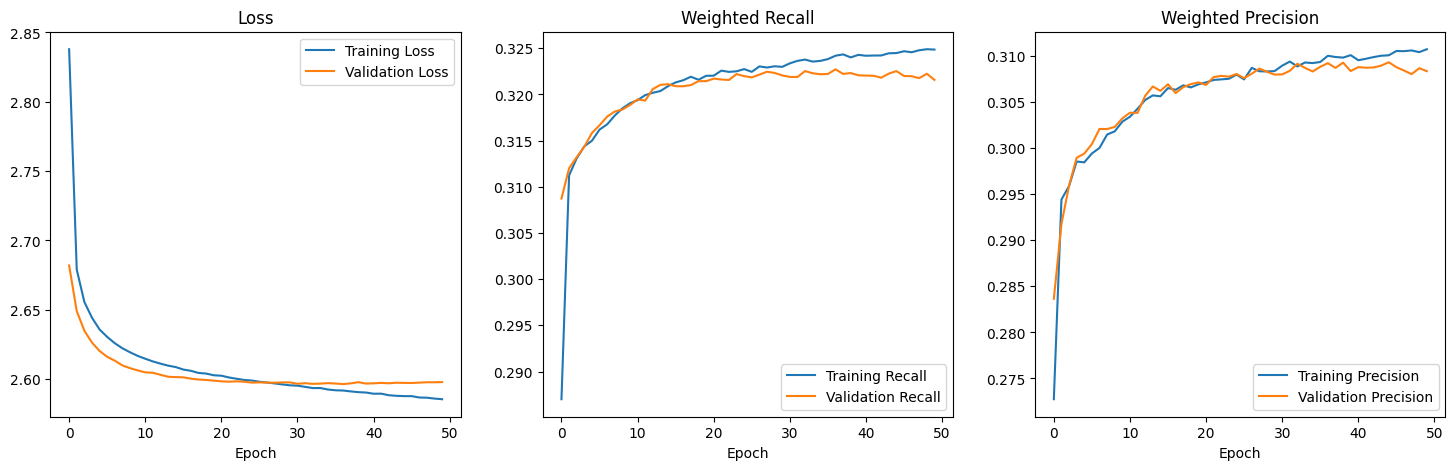

Training time: 1906.60s


In [22]:
EPOCHS = 50

# Training loop, starting with some statistics and setting up a table
start_time = time.perf_counter()
print("Training start:", time.asctime(time.localtime()))

header_printed = False
col_widths = []
table_seperator = ""

running_loss = 0.0
statistics = pd.DataFrame(columns=["Epoch", "Training Loss", "Validation Loss", "Training Recall", "Validation Recall", "Training Precision", "Validation Precision"])

model.to(device)
dataloader = combine_sequences(training_transactions)
for epoch in range(EPOCHS):
    epoch_start_time = time.perf_counter()
    
    training_accuracy = 0
    epoch_loss = 0.0
    y_true, y_pred = [], []

    #### Training phase ####
    model.train()
    for idx, (sequence, target) in enumerate(dataloader):
        sequence = sequence.to(device)
        target = target.to(device).long()
        # Predict
        out = model(sequence)
        # Calculate loss
        loss = loss_fn(out, target)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        predicted = torch.argmax(out, dim=1)

        y_true.extend(target.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

        epoch_loss += loss.item()
        training_accuracy += (predicted == target).sum().item()

    epoch_loss /= len(dataloader)
    running_loss += epoch_loss
    training_accuracy /= len(dataloader.dataset)

    # Precision & recall calculation for current epoch
    train_recall = metrics.recall_score(y_true, y_pred, average="weighted", zero_division=0.0)
    train_precision = metrics.precision_score(y_true, y_pred, average="weighted", zero_division=0.0)

    #### Validation phase ####
    val_accuracy, val_loss, val_recall, val_precision = run_validation()

    statistics.loc[len(statistics)] = [epoch, epoch_loss, float(val_loss), train_recall, val_recall, train_precision, val_precision]
    
    # Print table
    if not header_printed:
        header_printed = True
        header_text = "| Epoch | Validation Accuracy | Training Accuracy |     Validation Loss     |     Epoch Loss     |     Running Loss     | Epoch Time |"
        col_widths = [len(s)-2 for s in header_text.split("|")[1:-1]]
        table_seperator = f"+{'+'.join(['-' * (x + 2) for x in col_widths])}+"
        print(table_seperator)
        print(header_text)
        print(table_seperator)
    
    print(f"| {str(epoch + 1):<{col_widths[0]}} | "
              f"{f'{val_accuracy:.4%}':<{col_widths[1]}} | "
              f"{f'{training_accuracy:.4%}':<{col_widths[2]}} | "
              f"{f'{val_loss:.4f}':<{col_widths[3]}} | "
              f"{f'{epoch_loss:.4f}':<{col_widths[4]}} | "
              f"{f'{running_loss:.4f}':<{col_widths[5]}} | "
              f"{f'{time.perf_counter() - epoch_start_time:.2f}s':<{col_widths[6]}} |")
    
    # Save model after each epoch for analysis
    torch.save(model.state_dict(), BASE_PATH + f"LSTM_Model_Epoch_{epoch + 1}.pt")

statistics.set_index("Epoch", inplace=True)
print(table_seperator)

# Plot the statistics if the model is sufficiently trained
if EPOCHS > 5:
    plt.figure(figsize=(18, 5))
    statistics[["Training Loss", "Validation Loss"]].plot(ax=plt.subplot(1,3,1), title=f"Loss", legend=True)
    statistics[["Training Recall", "Validation Recall"]].plot(ax=plt.subplot(1,3,2), title=f"Weighted Recall", legend=True)
    statistics[["Training Precision", "Validation Precision"]].plot(ax=plt.subplot(1,3,3), title=f"Weighted Precision", legend=True)
    plt.show()
    statistics.to_csv(BASE_PATH + f"metrics.csv")


end_time = time.perf_counter()
print(f"Training time: {end_time - start_time:.2f}s")

In [23]:
statistics

,Training Loss,Validation Loss,Training Recall,Validation Recall,Training Precision,Validation Precision
Epoch,,,,,,
0.0,2.837891,2.681974,0.287003,0.308731,0.272739,0.283648
1.0,2.679009,2.649070,0.311236,0.312009,0.294438,0.291772
2.0,2.655670,2.634938,0.313091,0.313212,0.295898,0.295941
3.0,2.644305,2.626363,0.314385,0.314343,0.298564,0.298975
4.0,2.635804,2.620304,0.314992,0.315830,0.298477,0.299427
5.0,2.630448,2.616078,0.316199,0.316662,0.299439,0.300463
6.0,2.625883,2.613265,0.316767,0.317606,0.300044,0.302104
7.0,2.622226,2.609896,0.317719,0.318154,0.301495,0.302096
8.0,2.619353,2.607903,0.318499,0.318366,0.301847,0.302323


# Generate submission

In [24]:
sub = pd.read_csv('../data/sample_submission.csv')

In [25]:
# Model redefinition to make generating submissions easier without running previous cells
model = LSTMRecommender(
    input_dim=NUM_ARTICLES_IN_SEQUENCE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    n_articles=N_ARTICLES+1,
    bidirectional=False,
    num_layers=1,
    dropout=0.2
    )

In [26]:
# Epochs on the graph start from 0, however they are saved starting from 1
# Defining the optimal epoch for each sequence column, based on the validation loss graph
optimal_epoch = {
    "product_type_name": 25,
    "article_id": 10,
    "prod_name": 16,
}
model.load_state_dict(torch.load(BASE_PATH + f"LSTM_Model_Epoch_{optimal_epoch[SEQUENCE_COLUMN]}.pt"))
model.to(device)

LSTMRecommender(
  (embedding): Embedding(132, 64)
  (lstm): LSTM(64, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=132, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [27]:
# Double checking the transactions
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,prod_name,product_type_name,article_id_mapped
0,2018-09-20,1728846800780188,519773001,0.028458,2,0,7147,17,8050
1,2018-09-20,1728846800780188,578472001,0.032525,2,0,37340,38,18291
2,2018-09-20,2076973761519164,661795002,0.167797,2,0,43993,38,39546
3,2018-09-20,2076973761519164,684080003,0.101678,2,0,1768,6,45748
4,2018-09-20,2918879973994241,662980001,0.033881,1,0,2110,2,39897


In [28]:
# Sort the dataframe by "customer_id" and "t_dat" in descending order
df = transactions.sort_values(by=['customer_id', 't_dat'], ascending=[True, True])

# Group by "customer_id" and get the last 12 transactions for each customer
df_grouped = df.groupby('customer_id')['article_id_mapped' if SEQUENCE_COLUMN == "article_id" else SEQUENCE_COLUMN].apply(list)
transactions_filtered = pd.DataFrame({"customer_id": df_grouped.index, "sequence": df_grouped.apply(lambda x: x[-12:])})

In [29]:
# Convert customer ids to integers
customer_ids = sub.customer_id.apply(hex_id_to_int).tolist()

In [30]:
# Find missing customers if any
missing_customer_ids = list(set(customer_ids).difference(set(transactions_filtered.customer_id)))

In [31]:
# Create a new dataframe with the missing customer_ids and an empty list as the sequence
df_missing = pd.DataFrame({
  'customer_id': missing_customer_ids,
  'sequence': [[] for _ in range(len(missing_customer_ids))]
})

# Concatenate df_result and df_missing
transactions_filtered = pd.concat([transactions_filtered, df_missing])

In [32]:
# Sorting based on customer_ids in submission
transactions_df = transactions_filtered.copy()
transactions_df['customer_id'] = pd.Categorical(transactions_df['customer_id'], categories=customer_ids, ordered=True)
transactions_df_sorted = transactions_df.sort_values("customer_id")

In [33]:
transactions_df_sorted

,customer_id,sequence
6.883939e+18,6883939031699146327,"[25, 25, 4, 45, 2, 1, 3, 4, 6, 9, 2, 25]"
1.124633e+19,11246327431398957306,"[31, 31, 31, 31, 31, 20, 20, 20, 31, 31, 20, 2]"
1.843990e+19,18439897732908966680,"[20, 2, 2, 5, 11, 0, 0, 8, 8, 2, 2, 6]"
1.835267e+19,18352672461570950206,"[13, 13]"
1.816278e+19,18162778555210377306,"[2, 31, 20, 6, 6, 56, 56, 56, 3, 64, 1, 3]"
...,...,...
7.551062e+18,7551062398649767985,"[10, 20, 24, 47, 31, 13, 26, 15, 4, 3, 3, 10]"
9.305342e+18,9305341941720086711,"[34, 50, 31, 20, 15, 3, 3, 30, 3, 30, 9, 8]"
1.016043e+19,10160427316885688932,"[17, 0, 40, 40, 40, 0, 3, 2, 8, 1, 2, 8]"
2.551401e+18,2551401172826382186,"[10, 24, 0, 1, 3, 1, 10]"


In [34]:
history_dataset = HistoryDataset(transactions_df_sorted.sequence.tolist())
history_dataloader = DataLoader(history_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [35]:
if SEQUENCE_COLUMN != "article_id":
    articles_from_column = transactions.groupby(SEQUENCE_COLUMN)["article_id"].value_counts()
    articles_from_column = articles_from_column.groupby(level=0).apply(lambda x: x.index.get_level_values(1).tolist()).to_dict()
    
    # If the model predicts the padding value then we simply use one of the most sold articles instead
    articles_from_column[PADDING_ARTICLE] = transactions["article_id"].value_counts().nlargest(12).index.tolist()
else:
    most_popular = transactions["article_id"].value_counts().nlargest(12).index.tolist()

In [36]:
preds = []
counter = 0
history_batches = []
history_batch = []

for idx, batch in enumerate(tqdm(history_dataloader)):
    batch = batch.to(device)
    
    for i in range(12):
        # Pass padded batches to the model
        with torch.no_grad():
            out = model(batch[:, -12:])

            # random prediction sample based on probabilities
            out = sample_lstm(out, temperature=0.15)

        # Append model's output to each sequence in the batch
        batch = torch.cat((batch, out), dim=1)
    for i in range(batch.shape[0]):
        # Make actual predictions if column is not article_id
        customer_col_preds = batch[i, -12:].tolist()
        if SEQUENCE_COLUMN != "article_id":
            customer_preds = process_predictions(customer_col_preds, articles_from_column, PADDING_ARTICLE)
            preds.append(customer_preds)
        else:
            preds.append(process_mapped_predictions(batch[i, -12:].tolist(), inverse_article_id_map, most_popular))

100%|██████████| 10719/10719 [04:21<00:00, 40.96it/s]


In [37]:
import pickle
with open(BASE_PATH + f"rec_list.bin", "wb") as f:
    pickle.dump(preds, f)

In [38]:
with open(BASE_PATH + f"rec_list.bin", "rb") as f:
    some_list = pickle.load(f)

In [39]:
assert preds == some_list

In [40]:
transactions["article_id"].value_counts()

article_id
706016001    50287
706016002    35043
372860001    31718
610776002    30199
759871002    26329
             ...  
390531007        1
734529007        1
653907001        1
456641003        1
880582004        1
Name: count, Length: 104547, dtype: int64

In [41]:
_preds = [' '.join(['0' + str(p) for p in ps]) for ps in preds]
sub.prediction = _preds

In [ ]:
sub_name = f'lstm_model_submission_e{optimal_epoch[SEQUENCE_COLUMN]}.csv.gz'
sub.to_csv(BASE_PATH + sub_name, index=False)